This notebook is used to perform EDA on the training data from notebook 1.  

# Imports

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

import keijzer_exogan as ke

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab

# Initialize default seaborn layout
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
sns.set(style='ticks') 

# Loading data

In [3]:
%%time
path = '/datb/16011015/ExoGAN_data/selection//'
data = np.load(path+'last_chunks_25_percent.npy')
np.random.shuffle(data) # shuffle the array, make sure the distribution is random (by index atleast)

CPU times: user 46.2 s, sys: 12.7 s, total: 58.9 s
Wall time: 59.3 s


In [4]:
"""
data contains 10k dictionaries of 50 chunks
"""
data.shape

(50, 25000)

In [5]:
# Flattening the data so all simulations are on axis 1
data = data.flatten()

#data = data[:100000] # select a smaller sample to reduce the time required for analysis

data.shape

(1250000,)

# Plot spectra
These are not 'proper' spectra plots, but for EDA purposes it's fine.

In [6]:
wavelengths = ke.load_wavelengths()

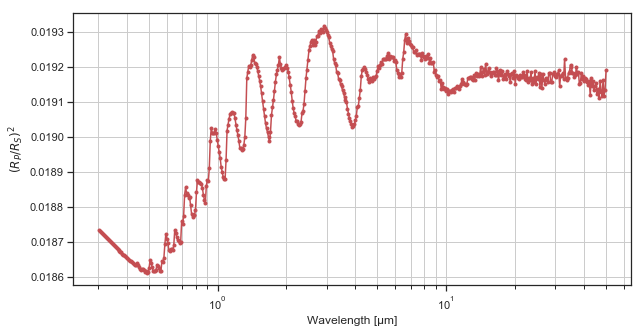

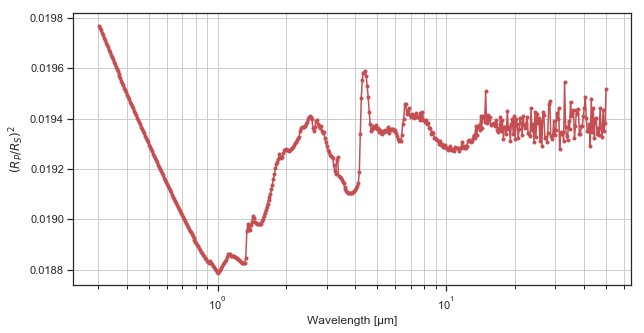

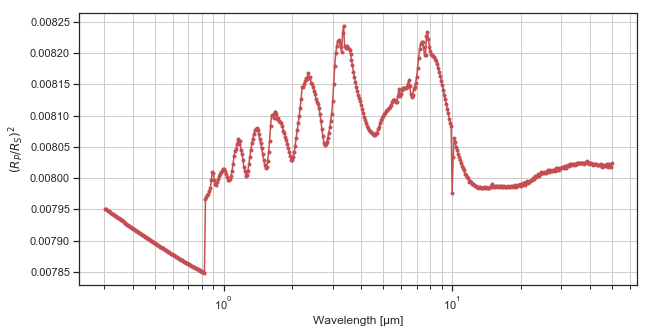

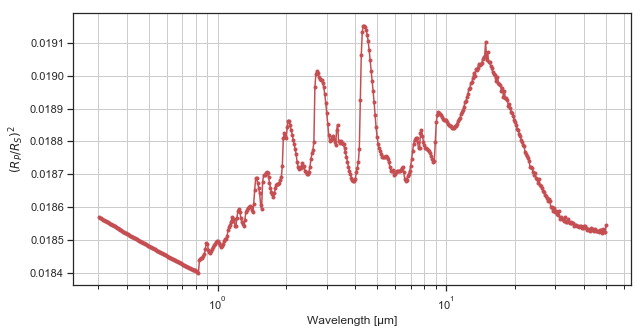

In [7]:
n = 4 # number of spectra to plot

indices = np.random.randint(0, len(data), size=n)

spectra = [data[i]['data']['spectrum'] for i in indices] # load the n randomly selected spectra into an array

df = pd.DataFrame(spectra).T # take the transpose so axis 0 are the R/R values
df['x'] = wavelengths


for i in range(n):
    ke.plot_spectrum(df.x, df[i])

(0.015, 0.03)

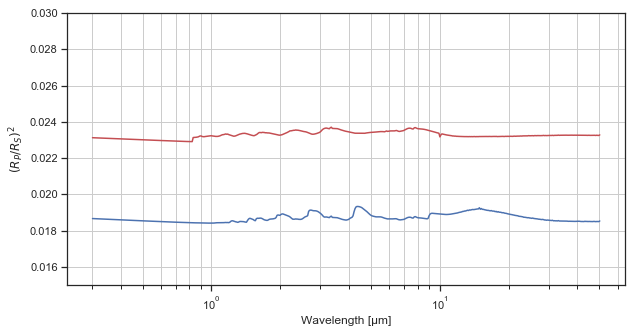

In [8]:
"""
Do the same thing but put it in one figure (with more spectra)
"""

# Grab a new sample

n = 4 # number of spectra to plot

indices = np.random.randint(0, len(data), size=n)

spectra = [data[i]['data']['spectrum'] for i in indices] # load the n randomly selected spectra into an array

df = pd.DataFrame(spectra).T # take the transpose so axis 0 are the R/R values
df['x'] = wavelengths

i=0
y = df[i].values.reshape(-1,1)
y.shape

# Plot the sample

plt.figure(figsize=(10,5))

for i in range(n):
    plt.plot(df.x, df[i])
    
plt.xlabel(r'Wavelength [µm]')
plt.ylabel(r'$(R_P / R_S)^2$')

plt.grid(True, which="both", ls='-')
    

plt.xscale('log')

plt.ylim((0.015,0.03))

(0.3, 16)

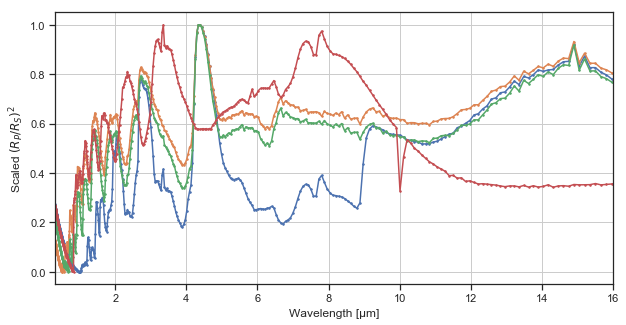

In [9]:
plt.figure(figsize=(10,5))

for i in range(n):
    y = df[i].values.reshape(-1,1)
    scaler = MinMaxScaler(feature_range=(0,1)).fit(y)
    y = scaler.transform(y)

    plt.plot(df.x, y, '.-', ms=3)
    
plt.xlabel(r'Wavelength [µm]')
plt.ylabel(r'Scaled $(R_P / R_S)^2$')

plt.grid(True, which="both", ls='-')


#plt.xscale('log')

plt.xlim((0.3,16))

# Wavelengths and indices

In [ ]:
df[['x']].to_csv('wavelengths_and_indices.csv')

# EDA on the params
Using multiprocessing to create the dfs cuts the creation time of `params` down from 10 minutes to 4 minutes (using 48 threads or 24 cores).

In [10]:
from multiprocessing import Pool

input_data = [(i) for i in range(len(data))] # input to f must be a tuple

def f(t):
    i = t
    param = pd.DataFrame(data[i]['param'], index=[0])
    return param

In [ ]:
%%time
pool = Pool() # server has 2x 12 cores -> Pool(processes=24)
params = pool.map(f, input_data, chunksize=1)

In [ ]:
%%time
pool.close()
pool.join()
pool.terminate() # not nice but meh, pool.join() gets stuck... https://stackoverflow.com/questions/15314189/python-multiprocessing-pool-hangs-at-join

In [ ]:
%%time
params = pd.concat(params)
params.head()

In [ ]:
params.info()

In [ ]:
params.describe()

In [ ]:
params.nunique()

# Transform mixratios from linear to logarithmic scale

In [ ]:
for param in params:
    if 'mixratio' in param:
        params[param] = np.log10(params[param])

params.describe()

In [ ]:
plt.figure(figsize=(20,10))

for i, param in enumerate(params.columns):
    plt.subplot(3,3,i+1)
    plt.grid(True, which="both", ls='-')
    
    if 'mixratio' in param:
        plt.title('%s (dex)' % param)
        plt.hist(params[param], bins=10)
        #plt.xscale('log')
    else:
        plt.title(param)
        plt.hist(params[param], bins=10)

plt.tight_layout()

In [ ]:
params.describe()

In [ ]:
params.info()

In [ ]:
params.nunique()